# Train Transformer Decoder
This notebook trains the Transformer Decoder that will be used to generate text and embeds it in a GPT class. It is based on the [Neural Machine Translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer) tutorial by TensorFlow.

In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_text as text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [125]:
import config

## Dataset and tokenizer
Load dataset and tokenizer, see the tokenization notebook for details.

In [126]:
train_dataset = tf.data.Dataset.load(config.TRAIN_DATA_PATH)
val_dataset = tf.data.Dataset.load(config.VAL_DATA_PATH)
tokenizer = tf.saved_model.load(config.TOKENIZER_PATH)

## Make batches
Split the tokenized dataset into input and target sequences, split into batches for model training.

In [127]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text


def make_batches(ds):
    return (
        ds.map(split_input_target, tf.data.AUTOTUNE)
        .batch(config.BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [128]:
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

## Decoder
Compile and train the Transformer Decoder model.

In [151]:
from model import Decoder, masked_loss, masked_accuracy, CustomSchedule

decoder = Decoder(
    num_layers=config.N_LAYERS,
    d_model=config.D_MODEL,
    num_heads=config.N_HEADS,
    dff=config.FFN_DIM,
    vocab_size=config.VOCAB_SIZE,
    dropout_rate=config.DROPOUT_RATE
)

In [152]:
# Build the transformer by applying it to a sample
for input_text, target_text in train_batches.take(1):
    break
decoder(input_text)
decoder.summary()

Model: "decoder_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding_7 (Po  multiple                  384000    
 sitionalEmbedding)                                              
                                                                 
 dropout_55 (Dropout)        multiple                  0         
                                                                 
 decoder_layer_24 (DecoderL  multiple                  199040    
 ayer)                                                           
                                                                 
 decoder_layer_25 (DecoderL  multiple                  199040    
 ayer)                                                           
                                                                 
 decoder_layer_26 (DecoderL  multiple                  199040    
 ayer)                                                   

In [153]:
from model import CustomSchedule

learning_rate = CustomSchedule(config.D_MODEL)
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate, **config.OPTIMIZER_KWARGS
)

Text(0.5, 0, 'Train Step')

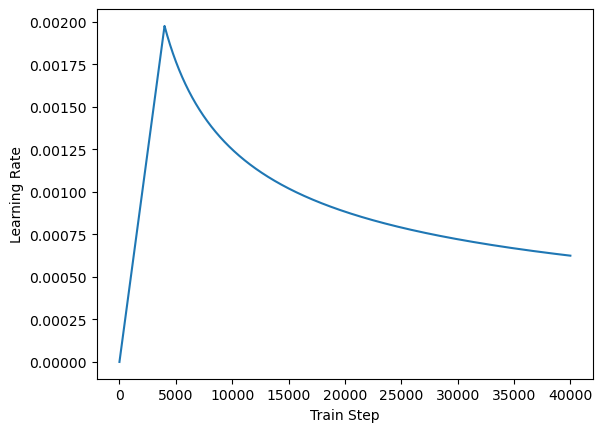

In [154]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [155]:
from model import masked_loss, masked_accuracy

decoder.compile(
    loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy]
)

In [ ]:
decoder.fit(
    train_batches, epochs=config.N_EPOCHS, validation_data=val_batches
)

Epoch 1/10
2165/4500 [=============>................] - ETA: 20:11 - loss: 5.8268 - masked_accuracy: 0.1209

## GPT
Use the Decoder model and tokenizer in a GPT.

In [147]:
output_length = 100

In [148]:
input = "king lear:"
tokens = tokenizer.tokenize([input]).to_tensor()
output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
output_array = output_array.unstack(tokens[0])

i = tokens.shape[1]

In [149]:
for _ in range(output_length):
    output_tensor = tf.expand_dims(output_array.stack(), axis=0)
    
    # Select the last predicted token from the `seq_len` dimension.
    predictions = decoder(output_tensor, training=False)[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
    predicted_token = tf.argmax(predictions, axis=-1)[0, 0]
    output_array = output_array.write(i, predicted_token)
    i += 1

In [150]:
predicted_tokens = tf.expand_dims(output_array.stack(), axis=0)
generated_text = tokenizer.detokenize(predicted_tokens).numpy()[0].decode("utf-8")
print(generated_text)

king lear : i am not fool , my lord . king lear : i am sorry , my lord , i have not yet . king lear : i am sorry , my lord , i have not yet . king lear : i am sorry for ' t . king lear : i have not yet . king lear : i have not yet . king lear : i have . king lear : i have . king lear : i have . king lear : i have . king lear : i have . king lear : i have .


In [106]:
print("king lear : what , are you mad ? fool : no , no , no ; i ' ll be sworn . fool : why , i ' ll be sworn , sir , i ' ll be sworn . fool : why , i ' ll be sworn i am a fool . fool : why , then , nuncle , i ' ll be sworn i am a fool . fool : why , then , nuncle , i ' ll be sworn i ' ll be sworn i am a fool . fool : why , fool , i")

king lear : what , are you mad ? fool : no , no , no ; i ' ll be sworn . fool : why , i ' ll be sworn , sir , i ' ll be sworn . fool : why , i ' ll be sworn i am a fool . fool : why , then , nuncle , i ' ll be sworn i am a fool . fool : why , then , nuncle , i ' ll be sworn i ' ll be sworn i am a fool . fool : why , fool , i
